# === STEP 1 & STEP 2: SETUP ===


In [1]:
# === STEP 1: SETUP ===
# Install the "scanpy" library (Standard for Single-Cell Analysis)
# Install "leidenalg" (The specific math for clustering cells)
!pip install scanpy leidenalg --quiet

import scanpy as sc
import pandas as pd
import numpy as np

# Configure "Pretty Plots" (Publication Quality)
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# === STEP 2: INGESTION (Bronze Layer) ===
# Load the PBMC 3k dataset (Healthy Blood Cells)
adata = sc.datasets.pbmc3k()

# === VALIDATION ===
# Print the shape to prove we have data
print(f"\n✅ SUCCESS: Data Loaded.")
print(f"Dimensions: {adata.n_obs} Cells (Rows) x {adata.n_vars} Genes (Columns)")

# Show the first 5 genes just to see what they look like
print(f"Example Genes: {adata.var_names[:5].tolist()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 65.4 MB/s eta 0:00:00
try downloading from url
https://falexwolf.de/data/pbmc3k_raw.h5ad
... this may take a while but only happens once


/tmp/ipython-input-3029898443.py:13: FutureWarning: Use `scanpy.set_figure_params` instead
  sc.settings.set_figure_params(dpi=80, facecolor='white')


  0%|          | 0.00/5.58M [00:00<?, ?B/s]


✅ SUCCESS: Data Loaded.
Dimensions: 2700 Cells (Rows) x 32738 Genes (Columns)
Example Genes: ['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8']


# === STEP 3: QUALITY CONTROL (QC) ===

Finding the "dead" or "low quality" cells and remove them

The Logic:

Mitochondrial Genes (MT-): When a cell dies, its membrane breaks, and mitochondrial RNA leaks out. High MT- % = Dead Cell.

Gene Count:

Too few genes (< 200) = Empty Droplet (no cell inside).

Too many genes (> 2500) = Doublet (two cells stuck together).

Cells BEFORE filtering: 2700


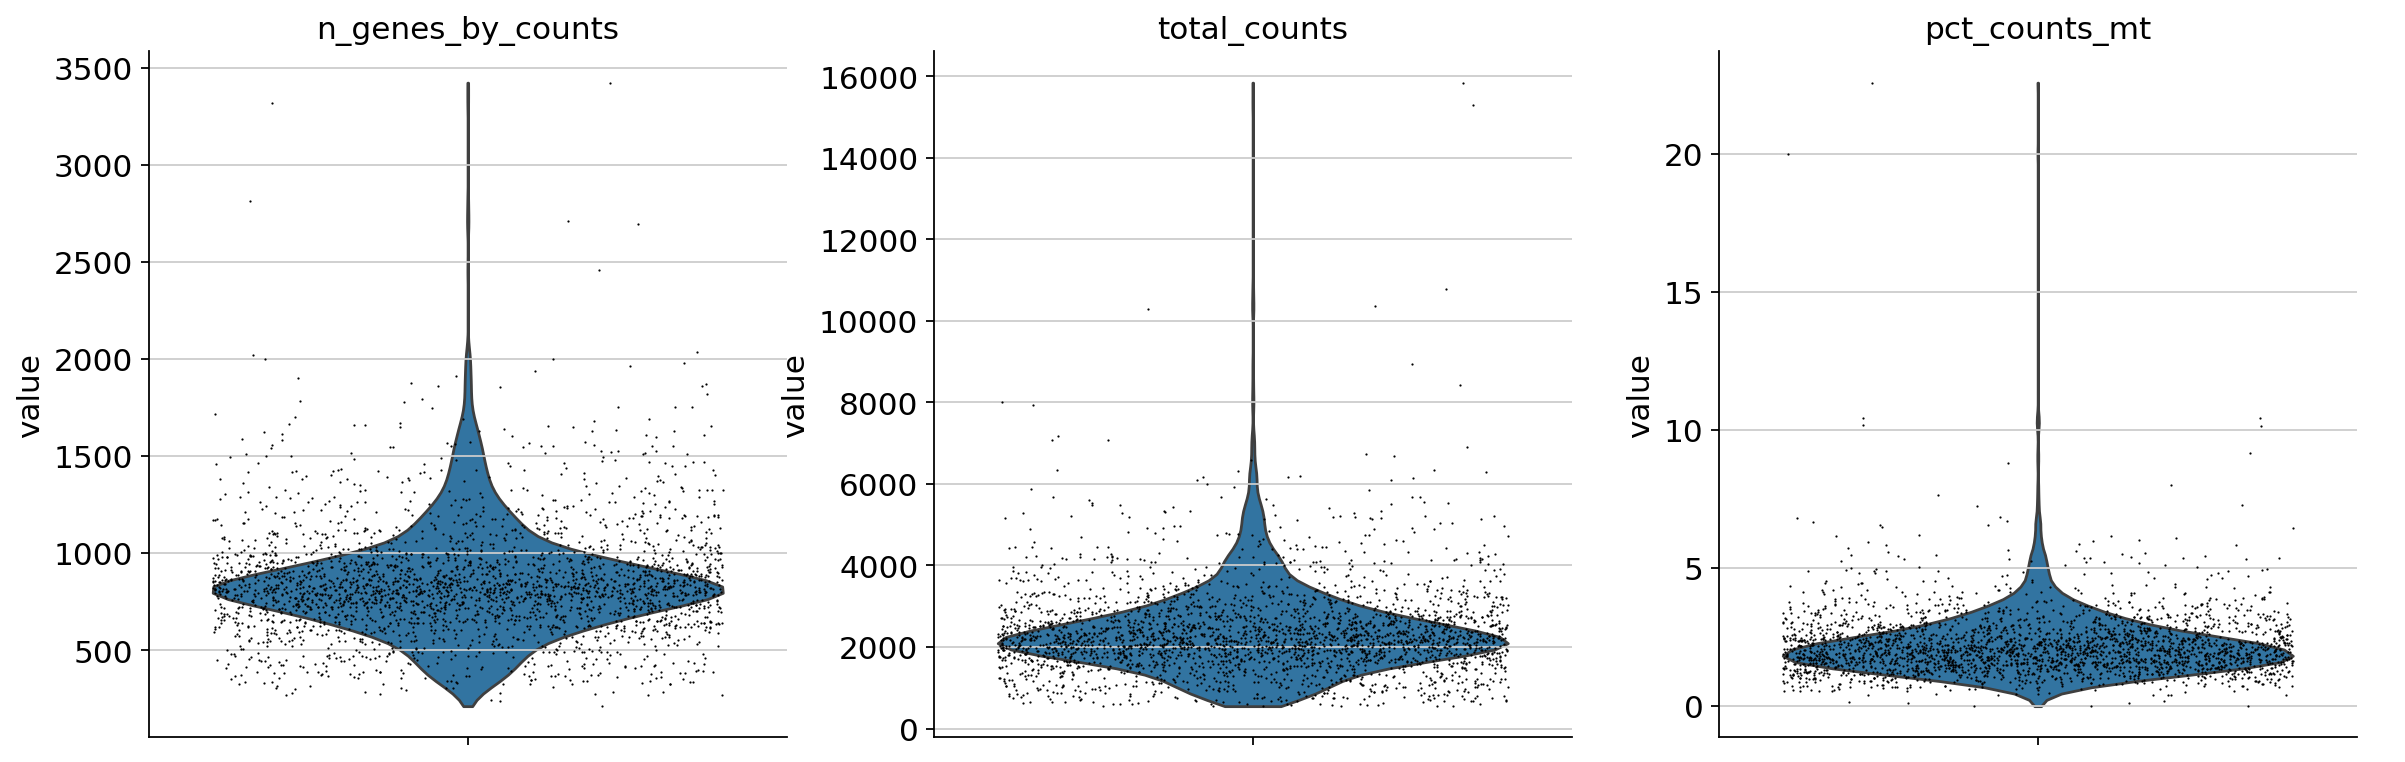

Cells AFTER filtering: 2638


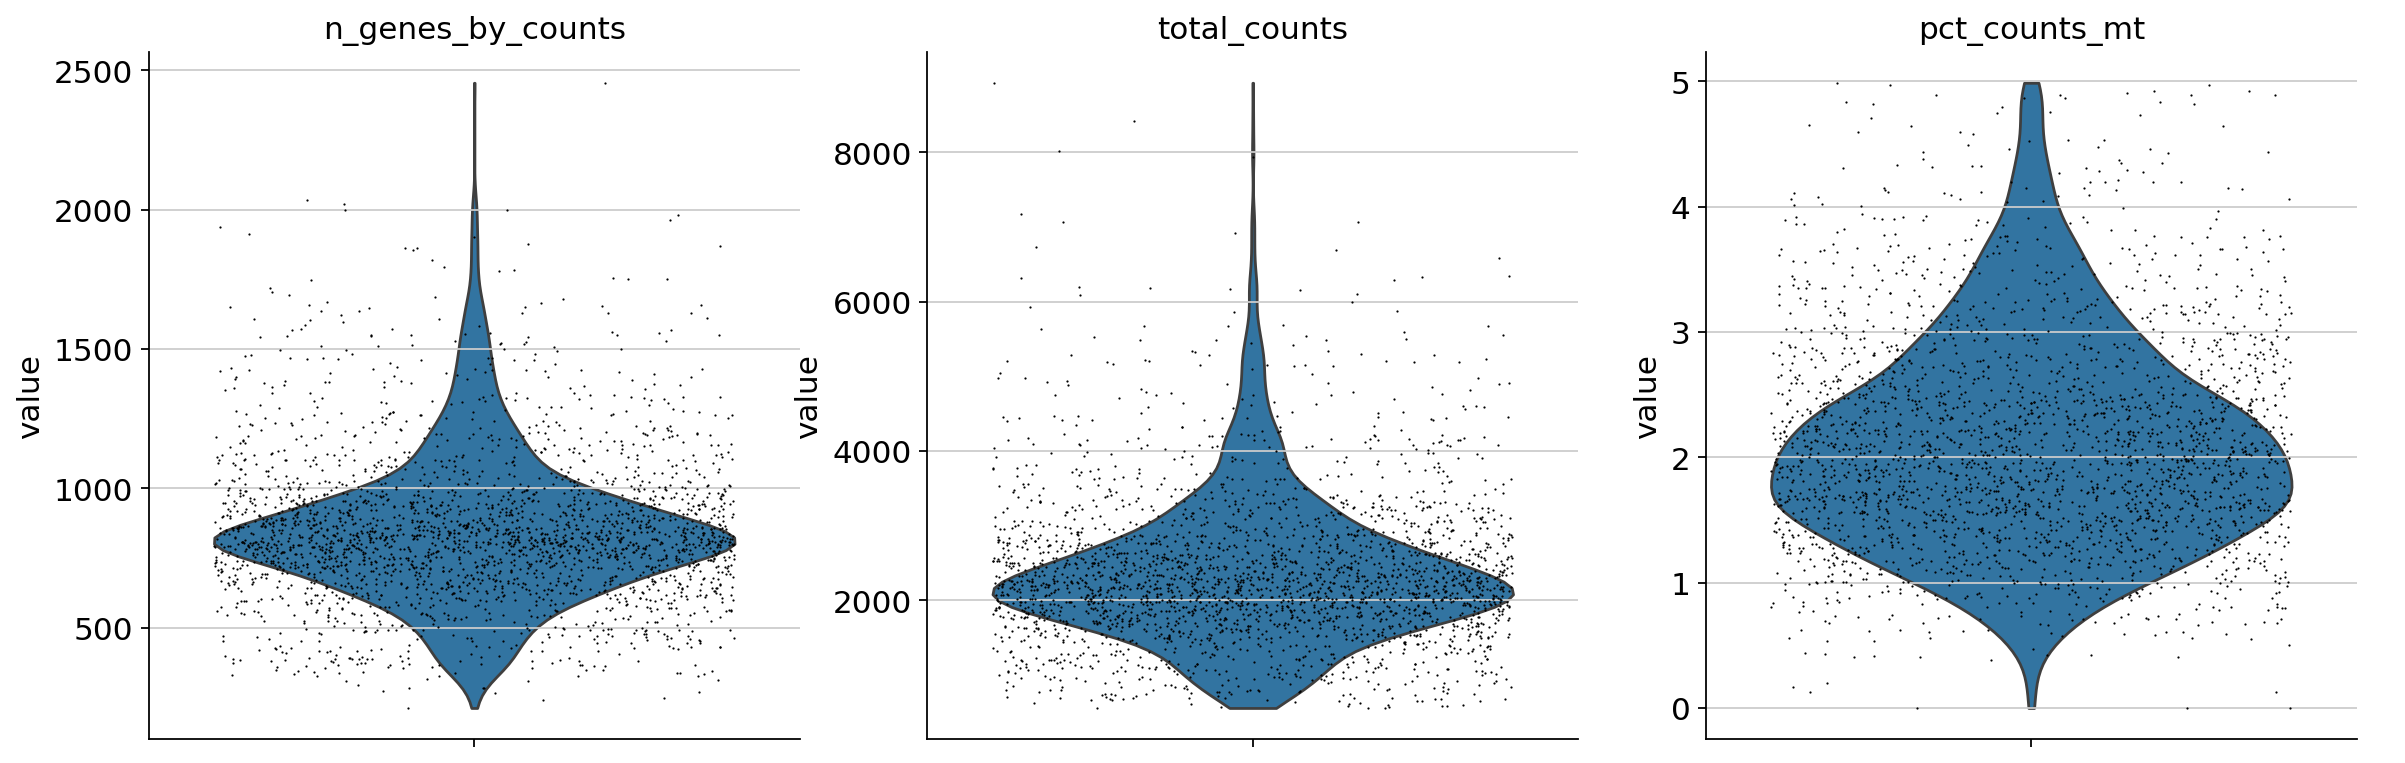

In [2]:
# === STEP 3: QUALITY CONTROL (QC) ===

# 1. Flag Mitochondrial Genes (Start with "MT-")
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# 2. Calculate QC Metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# 3. VISUALIZE "BEFORE" (Evidence of Garbage)
print(f"Cells BEFORE filtering: {adata.n_obs}")
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

# 4. APPLY FILTERS (The Cleaning)
# Keep cells with < 5% mitochondrial reads (Alive)
# Keep cells with < 2500 genes (Singlets)
# Keep cells with > 200 genes (Real cells)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# 5. VISUALIZE "AFTER" (Proof of Quality)
print(f"Cells AFTER filtering: {adata.n_obs}")
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Raw Input: 2700 Cells.

Clean Output: 2638 Cells.

Garbage Removed: 62 Cells (2.3%).

# === STEP 4: NORMALIZATION & LOG TRANSFORMATION ===

Preparing the clean data for the math algorithms.

Sequencing Depth: Some cells have 5,000 reads, others have 20,000. We can't compare them directly. We must "scale" them to be equal (Normalize).

Variance: Most genes (like the ones that build the cell wall) never change. They are boring. We only care about the "Highly Variable Genes" that make a T-Cell different from a B-Cell.

In [3]:
# === STEP 4: NORMALIZATION & LOG TRANSFORMATION ===

# 1. Normalize counts to 10,000 reads per cell (scaling)
# This ensures a "loud" cell doesn't drown out a "quiet" cell
sc.pp.normalize_total(adata, target_sum=1e4)

# 2. Logarithmize (log1p)
# Biology is exponential; Math likes linear. This fixes that.
sc.pp.log1p(adata)

# 3. Identify Highly Variable Genes (Feature Selection)
# We don't need all 32,000 genes. We only need the ~2,000 that act as "identifiers."
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# 4. Save the "Raw" state before we mess with scaling further
# (Standard engineering practice: Keep a backup of the 'count' data)
adata.raw = adata

# 5. Filter the dataset to keep ONLY the variable genes
adata = adata[:, adata.var.highly_variable]

# 6. Regress out effects of total counts and mitochondrial genes
# (Optional advanced step: removes technical noise)
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# 7. Scale each gene to unit variance (Z-score)
# Clip values exceeding standard deviation 10
sc.pp.scale(adata, max_value=10)

# VERIFICATION
print(f"Data dimensions after Feature Selection: {adata.n_obs} Cells x {adata.n_vars} Genes")

normalizing counts per cell


/tmp/ipython-input-691147264.py:5: UserWarning: Received a view of an AnnData. Making a copy.
  sc.pp.normalize_total(adata, target_sum=1e4)


    finished (0:00:05)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/tmp/ipython-input-691147264.py:24: UserWarning: Received a view of an AnnData. Making a copy.
  sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:657: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:657: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff


    finished (0:00:02)
Data dimensions after Feature Selection: 2638 Cells x 2013 Genes


# === STEP 5: CLUSTERING & DIMENSIONALITY REDUCTION ===

We need to find the "groups" (cell types).

The Logic:

PCA (Principal Component Analysis): Compresses the 2,013 genes down to 50 essential features.

Neighborhood Graph: Calculates "Who is similar to whom?" based on those 50 features.

Leiden Clustering: The algorithm that cuts the graph into distinct communities (Clusters 0, 1, 2...).

UMAP: The magic math that squashes those 50 dimensions into 2 dimensions (X, Y) so we can plot it.

computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:08)
running Leiden clustering


/tmp/ipython-input-3500820612.py:17: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata, resolution=0.5)


    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


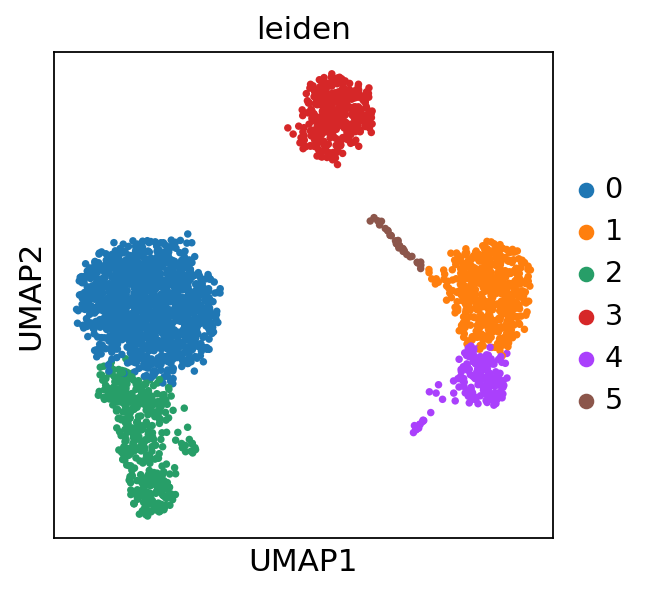

In [4]:
# === STEP 5: CLUSTERING & DIMENSIONALITY REDUCTION ===

# 1. Principal Component Analysis (PCA)
# Reduce 2000 genes -> 50 "Principal Components"
sc.tl.pca(adata, svd_solver='arpack')

# 2. Neighborhood Graph
# Calculate which cells are neighbors based on the PCA features
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# 3. UMAP (Uniform Manifold Approximation and Projection)
# Squash the 50 dimensions into 2D so we can see it
sc.tl.umap(adata)

# 4. Leiden Clustering
# Detect communities of cells (Resolution 0.5 is standard for small datasets)
sc.tl.leiden(adata, resolution=0.5)

# 5. VISUALIZE (The Payoff)
# Plot the UMAP and color it by the clusters we just found
sc.pl.umap(adata, color=['leiden'])

# === STEP 6: BIOLOGICAL VALIDATION ===

We need to prove that Cluster 0 = T-Cells. We look for specific "Marker Genes."

CD3E: The universal badge for T-Cells.

MS4A1 (CD20): The badge for B-Cells.

CST3: The badge for Monocytes.

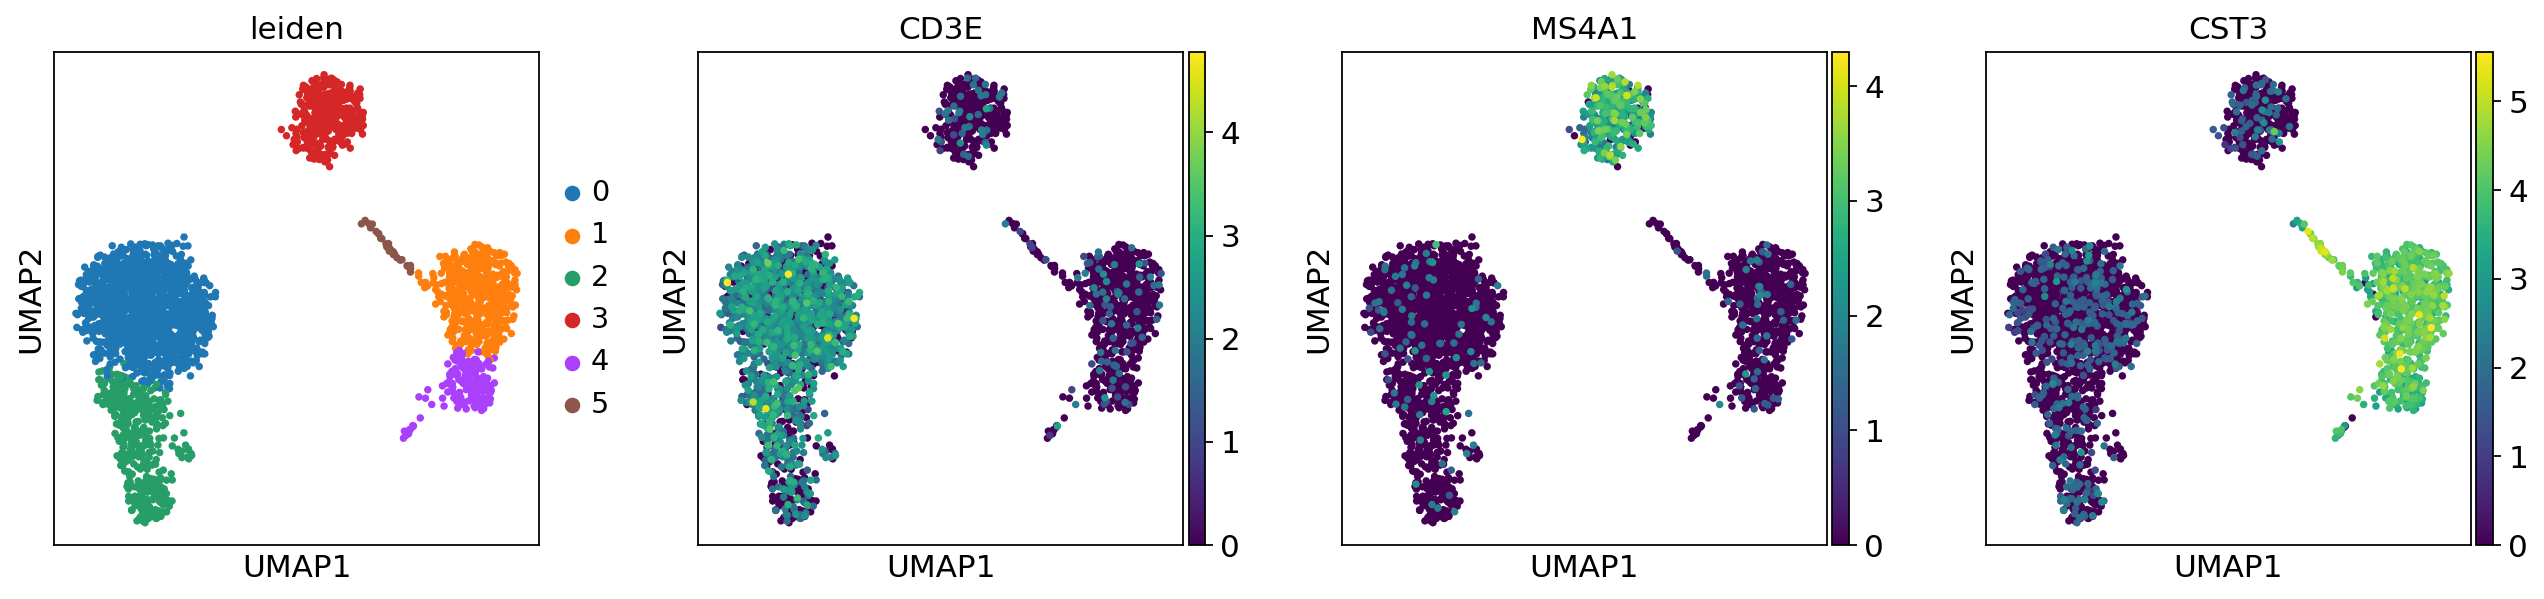

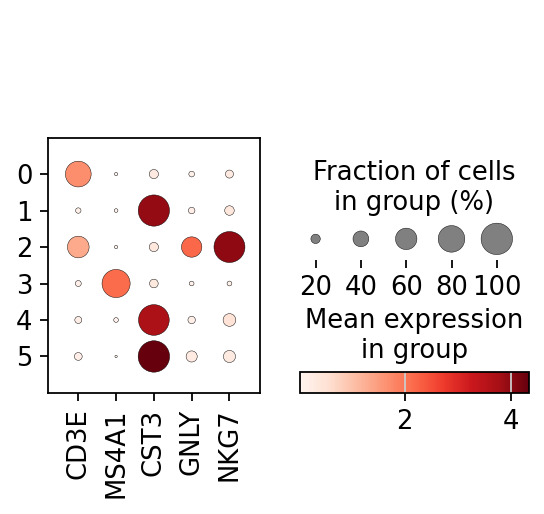

In [5]:
# === STEP 6: BIOLOGICAL VALIDATION ===

# 1. Color the UMAP by Marker Genes
# If a blob lights up "Red" for CD3E, it is a T-Cell.
sc.pl.umap(adata, color=['leiden', 'CD3E', 'MS4A1', 'CST3'])

# 2. Rename the Clusters (Annotation)
# Based on the plot, we manually label them.
# Note: These IDs (0,1,2...) might change slightly every time you run it,
# so we usually look at the plot first. For now, let's just see the genes.

# 3. ADVANCED VIZ: The Dot Plot (Pharma Standard)
# This summarizes the expression of these genes across all clusters
marker_genes = ['CD3E', 'MS4A1', 'CST3', 'GNLY', 'NKG7']
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

# === STEP 7: ANNOTATION ===

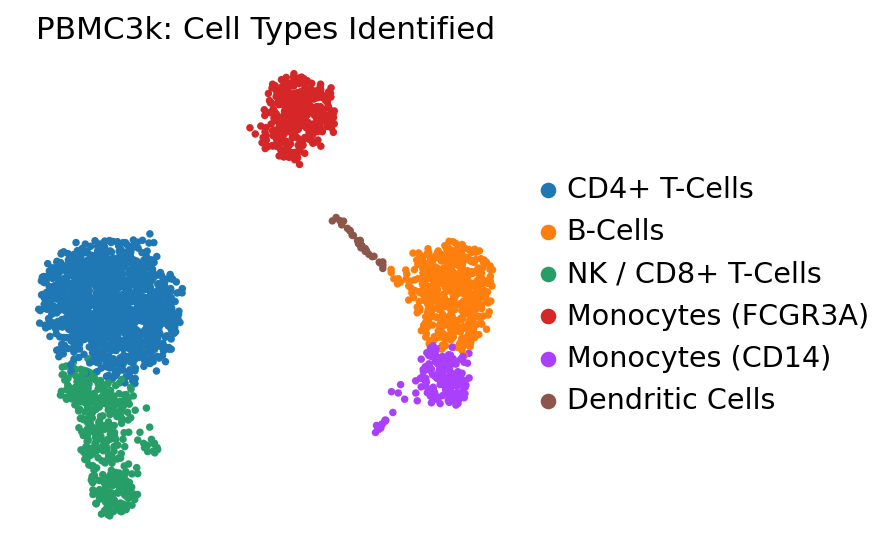

✅ Phase 1 Complete. Pipeline verified on healthy data.


In [6]:
# === STEP 7: ANNOTATION ===

# 1. Create a dictionary to map Numbers -> Names
# (Based on your specific dot plot results)
new_cluster_names = {
    '0': 'CD4+ T-Cells',      # The main T-Cell group (High CD3E)
    '1': 'B-Cells',           # The MS4A1 group
    '2': 'NK / CD8+ T-Cells', # The NKG7 + CD3E group
    '3': 'Monocytes (FCGR3A)',# The CST3 group 1
    '4': 'Monocytes (CD14)',  # The CST3 group 2
    '5': 'Dendritic Cells'    # The smallest CST3 group
}

# 2. Apply the names to a new column called 'cell_type'
adata.obs['cell_type'] = adata.obs['leiden'].map(new_cluster_names)

# 3. Plot the Final "Gold Layer" UMAP
sc.pl.umap(adata, color='cell_type', title='PBMC3k: Cell Types Identified', frameon=False)

# 4. Save your work (Checkpoint)
# This saves the whole object so you don't have to re-run everything tomorrow
adata.write('pbmc3k_processed.h5ad')
print("✅ Phase 1 Complete. Pipeline verified on healthy data.")